In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm.autonotebook import tqdm

assert(torch.cuda.is_available())
gpu = torch.device("cuda")

In [69]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [70]:
t1 = torch.rand([5,4])
t2 = torch.rand([3,6])

td = {"t1": t1, "t2": t2}
print(td["t1"].device)
td_gpu = moveTo(td, gpu)
print(td_gpu["t2"].device)
td_cpu = moveTo(td_gpu, "cpu")
print(td_cpu["t2"].device)

cpu
cuda:0
cpu


(200,)
(200, 1)


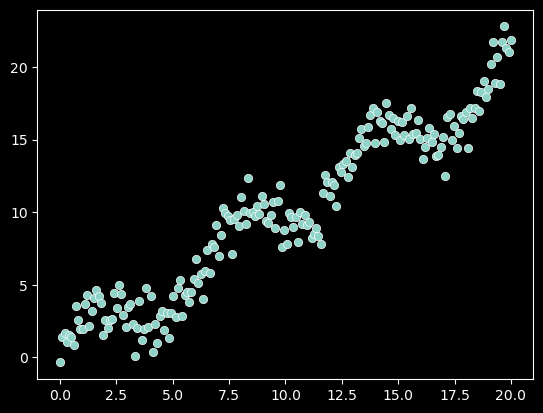

In [71]:
X = np.linspace(0, 20, num = 200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x = X, y = y)
print(X.shape)
print(X.reshape(-1, 1).shape)

In [72]:
class Simple1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

    def __getitem__(self, index):
        return torch.tensor(self.X[index, :], dtype=torch.float32), torch.tensor(self.y[index,:], dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]

dataset = Simple1DRegressionDataset(X, y)
print(dataset[0][0], dataset[0][1])

train_loader1 = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True, batch_size=1)
train_loader8 = DataLoader(Simple1DRegressionDataset(X, y), shuffle=False, batch_size=8)

batch1 = next(iter(train_loader1))
batch8 = next(iter(train_loader8))
print(type(batch1))
print(batch1[0].shape)
print(batch1[1].shape)
print(batch8[0].shape)
print(batch8[1].shape)

#the DataLoader splits the Dataset in batches of the specified size, and on each iteration, it returns
#a tensor of batch_size x n_features from X and a batch_size x 1 tensor of the corresponding y values 


tensor([0.]) tensor([-0.3583])
<class 'list'>
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([8, 1])
torch.Size([8, 1])


In [73]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
f_loss = nn.MSELoss()

print(hasattr(model, "to"))
print(list(model.parameters()))
test_input8 = next(iter(train_loader8))
test_output8 = model(test_input8[0])
test_input_scalar = test_input8[0][0]
test_output_scalar = model(test_input_scalar)
print(test_output_scalar)
print(test_output8)

True
[Parameter containing:
tensor([[0.3791]], requires_grad=True), Parameter containing:
tensor([0.3322], requires_grad=True)]
tensor([0.3322], grad_fn=<AddBackward0>)
tensor([[0.3322],
        [0.3703],
        [0.4084],
        [0.4465],
        [0.4846],
        [0.5227],
        [0.5608],
        [0.5989]], grad_fn=<AddmmBackward0>)


In [74]:
def train_simple_network(model, f_loss, loader, epochs = 20, device = "cpu"):
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
    model.to(device)

    for epoch in tqdm(range(epochs), desc = "Epoch"):
        model = model.train()
        running_loss = 0.0
        
        # for inputs, labels in tqdm(loader, desc = "Batch", leave = False):
        for inputs, labels in loader:
            #in each execution of this inner for loop, we operate on one batch provided by loader
            #inputs and labels will be lists of tensors of length given by loader's batch_size
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            optimizer.zero_grad()

            y_hat = model(inputs)
            loss = f_loss(y_hat, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    model.cpu()

In [75]:
train_simple_network(model, f_loss, train_loader8, device=gpu)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

<Axes: >

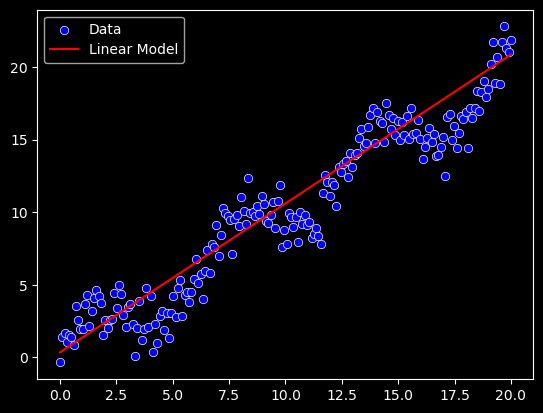

In [76]:
with torch.no_grad():
    X_test = torch.tensor(X, dtype=torch.float32).reshape(-1, 1).to(gpu)
    y_pred = model(X_test).cpu().numpy().ravel()

y_pred.shape

sns.scatterplot(x=X, y=y, color='blue', label='Data')
sns.lineplot(x=X, y=y_pred, color='red', label='Linear Model')

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

<Axes: >

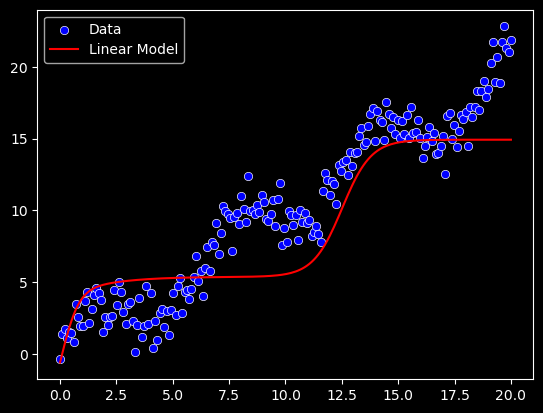

In [78]:
model2 = nn.Sequential(nn.Linear(1,10), nn.Tanh(), nn.Linear(10,1))
train_simple_network(model2, f_loss, train_loader1, device=gpu, epochs=200)
with torch.no_grad():
    X_test = torch.tensor(X, dtype=torch.float32).reshape(-1, 1).to(gpu)
    y_pred2 = model2(X_test).cpu().numpy().ravel()

sns.scatterplot(x=X, y=y, color='blue', label='Data')
sns.lineplot(x=X, y=y_pred2, color='red', label='Linear Model')

<Axes: >

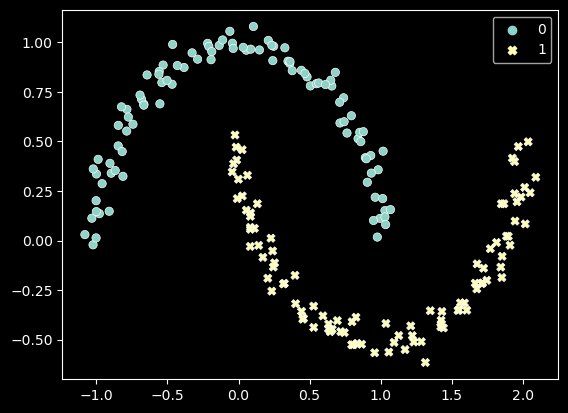

In [121]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

In [122]:
dataset_cls = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32),
    torch.tensor(y, dtype=torch.long)
)
training_loader_cls = DataLoader(dataset_cls)

model_cls = nn.Linear(in_features=2, out_features=2)
f_loss_cls = nn.CrossEntropyLoss()

In [123]:
train_simple_network(model_cls, f_loss_cls, training_loader_cls, device=gpu, epochs=50)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

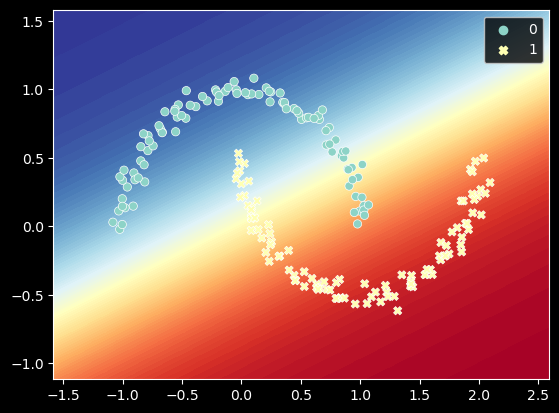

In [137]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    #create a grid of (x, y) points in which to evaluate the model
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    #stack all x and y coordinates in 1D vectors and stack them horizontally in a 400x2 array
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    #the Linear input layer in our model expects a tensor of size n_batch x in_features (2) and outputs 
    #a tensor of logits of size n_batch x out_features (2)
    with torch.no_grad():
        model.cpu()
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        #we apply softmax along the second dimension to convert the two values of each of the n_batch
        #outputs to a probability distribution
        y_hat = F.softmax(logits, dim=1).numpy()
    #plot a contour of the first of the two probability values 
    cs = plt.contourf(
        xv, yv, y_hat[:,0].reshape(20, 20),
        levels=np.linspace(0,1,num=100),
        cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

visualize2DSoftmax(X, y, model_cls, None)

In [139]:
model_cls2 = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30,2)
)
train_simple_network(model_cls2, f_loss_cls, training_loader_cls, epochs=250)

Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

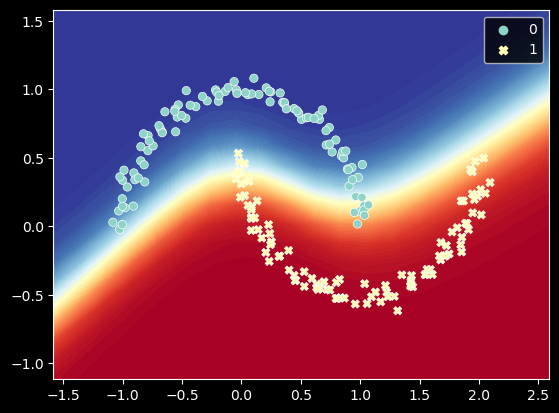

In [140]:
visualize2DSoftmax(X, y, model_cls2, None)